# División de Ciencias e Ingenierías de la Universidad de Guanajuato
## Fundamentos de procesamiento digital de imágenes
## Segundo Examen Parcial
### Profesor : Dr. Arturo González Vega
### Alumno : Gustavo Magaña López

## Módulos necesarios :

In [1]:
from typing import Tuple

import numpy as np
import scipy.fftpack as F
import scipy.io as io

import cv2
import matplotlib.image as img

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage
import skimage.morphology
import skimage.filters

In [2]:
plt.rcParams['figure.figsize'] = (5, 5)

## Definición de funciones :

In [ ]:
def img_fft(image: np.ndarray, shift: bool = True) -> np.ndarray:
    """
        Ejecutar una Transformada de Fourier visualizable con matplotlib.pyplot.imshow() .
        
        Basado en un snippet encontrado en :
        https://medium.com/@y1017c121y/python-computer-vision-tutorials-image-fourier-transform-part-2-ec9803e63993
        
        Parámetros :
                image : Imagen, representada como un arreglo de numpy (numpy.ndarray)
                shift : Booleano que indica si debe ejecutarse la traslación de la imagen e
                        en el espacio de frecuencia.
    """
    _X = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    if shift:
        _X_shift = np.fft.fftshift(_X)
    _X_complex = _X_shift[:,:,0] + 1j*_X_shift[:,:,1]
    _X_abs = np.abs(_X_complex) + 1 # Evitar que el logaritmo reciba 0 como argumento.
    _X_bounded = 20 * np.log(_X_abs)
    _X_img = 255 * _X_bounded / np.max(_X_bounded)
    _X_img = _X_img.astype(np.uint8)
    
    return _X_img
##

def fft_viz(image: np.ndarray, shift: bool = True) -> None:
    """
        Ver la transformada de fourier de una imagen.
    """
    plt.imshow(img_fft(image, shift=shift), cmap='gray')
    

def paddedsize(*args, **kwargs) -> Tuple[int]:
    """
        ### DEPRECATED ! ###
        
        OpenCV has a better implementation :
        https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#fourier-transform
    
        Traducción a Python3.7 de la función definida en:
        Gonzalez Image Processing with MATLAB
        Capítulo 4, Sección 3 :  'Filtering in the frequency domain', página 117
        
        Docstring (adaptación del original): 
        PADDEDSIZE Computes padded sizes useful for FFT-based filtering.
        PADDEDSIZE calcula los tamaños 'amortiguados' adecuados para filtrado FFT. 
        
        El parámetro 'PWR2' puede también ser especificado con minúsculas.
        i.e. 'pwr2'
        
        PQ = PADDEDSIZE(AB)
            Donde AB es una lista/vector/arreglo de dos elementos, 
            calcula el vector PQ tal que :
                PQ = 2 * AB
        
        PQ = PADDEDSIZE(AB, 'PWR2')
            Calcula el vector PQ tal que :
                PQ[0] = PQ[1] = 2**ceil(log2(abs(2*m)))
                donde m = max(AB)
                
        PQ = PADDEDSIZE(AB, CD)
            Donde AB y CD son listas/vectores/arreglos de dos elementos, 
            calcula el vector PQ. 
            Los elementos de PQ son los enteros pares más pequeños, 
            mayores o iguales que AB + CD - 1
            
        PQ = PADDEDSIZE(AB, CD, 'PWR2')
            Parecido a PADDEDSIZE(AB, 'PWR2'), sólo que
            toma en cuenta todos los valores contenidos
            tanto en AB, como en CD.
                P[0] = P[1] = 2**ceil(log2(abs(2*m)))
                donde m = max([*AB, *CD])
                
        PQ es de tipo 'Tuple', conteniendo 2 enteros.
    """
    
    nargin = len(args)
    
    if nargin == 0:
        print('Error, especificar al menos un parámetro.')
        print(paddedsize.__doc__)
        return None
    elif nargin == 1:
        try:
            AB = np.array(args[0])
        except:
            raise Exception(f'AB es un objeto de la clase {type(args[0])}, no puede ser convertido a np.array')
        PQ = 2 * AB
    elif nargin == 2 and type(args[1]) is not str:
        try:
            AB = np.array(args[0])
            CD = np.array(args[1])
        except:
            _e = f'AB es un objeto de la clase {type(args[0])}, CD de la clase {type(args[1])}\n'
            _e += 'Alguno de los dos no pudo ser convertido a np.array'
            raise Exception(_e)
        PQ = AB + CD - 1
        PQ = 2 * np.ceil(PQ / 2)
    elif nargin == 2 and type(args[1]) is str:
        try:
            AB = np.array(args[0])
        except:
            raise Exception(f'AB es un objeto de la clase {type(args[0])}, no puede ser convertido a np.array')
        m  = AB.max()
        P  = 2**np.ceil(np.log2(np.abs(2 * m)))
        PQ = [P, P]
    elif nargin == 3 and type(args[2]) is str:
        try:
            AB = np.array(args[0])
            CD = np.array(args[1])
        except:
            _e = f'AB es un objeto de la clase {type(args[0])}, CD de la clase {type(args[1])}\n'
            _e += 'Alguno de los dos no pudo ser convertido a np.array'
            raise Exception(_e)
        m  = max([*AB, *CD])
        P  = 2**np.ceil(np.log2(np.abs(2 * m)))
        PQ = [P, P]
    else:
        print('Error, número o tipo de parámetros incorrectos.')
        print(paddedsize.__doc__)
        return None
    
    return tuple(PQ)
##

def pre_fft_processing(image: np.ndarray) -> np.ndarray:
    """
    """
    
    row, cols = image.shape
    nrows, ncols = list(map(cv2.getOptimalDFTSize, image.shape))
    right = ncols - cols
    bottom = nrows - rows
    bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
    nimg = cv2.copyMakeBorder(image,0,bottom,0,right,bordertype, value = 0)
    
    return nimg
##

def fft2(image: np.ndarray):
    """
    """
    nimg = pre_fft_processing(image)
    dft2 = cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    
    return dft2
##

def ImPotencia(image: np.ndarray) -> float:
    """
    Calcula la potencia de acuerdo al teorema de Parseval.
    """
    _F = np.fft.fft2(image)
    return np.sum(np.abs(_F)**2) / np.prod(_F.shape)
##

def fourier_meshgrid(image: np.ndarray):
    """
    """
    M, N = image.shape
    u, v = list(map(lambda x: np.arange(0, x), image.shape))
    idx, idy = list(map(lambda x, y: np.nonzero(x > y/2), [u, v], image.shape))
    u[idx] -= M
    v[idy] -= N
    V, U = np.meshgrid(v, u)
    
    return U, V
##

def fourier_distance(U: np.ndarray, V: np.ndarray, centered: bool = True, squared: bool = True) -> np.ndarray:
    """
    """
    _d = U**2 + V**2
    if not squared:
        _d = np.sqrt(_d)
    if centered:
        _d = np.fft.fftshift(_d)
    
    return _d
    
def kernel_gaussiano(image: np.ndarray, sigma: float, kind: str = 'low') -> np.ndarray:
    """
        Calcula un kernel gaussiano para una imagen dada.
    """
    U, V = fourier_meshgrid(image)
    D = fourier_distance(U, V)
    H = np.exp( (-1.0 * D) / (2.0 * sigma**2) )
    
    if kind == 'high' or kind == 'highpass':
        H = 1.0 - H
        
    return H
##
    
def FiltraGaussiana(image: np.ndarray, sigma: float, kind: str = 'low') -> np.ndarray:
    """
    
    """
    kind   = kind.lower()
    _kinds = ['low', 'high', 'lowpass', 'highpass']
    if kind not in _kinds:
        raise Exception(f'Error : Tipo desconocido de filtro \"{kind}\".\n Tipos disponibles : {_kinds}')
    
    H  = kernel_gaussiano(image=image, sigma=sigma, kind=kind)
    _F = np.fft.ifftshift(
            np.fft.fft2(image)
    )
    G  = H * _F
    g  = np.real( np.fft.ifft2( np.fft.ifftshift(G) ))
    
    # Recortamos la imagen a su tamaño original, de ser requerido.
    g = g[:image.shape[0], :image.shape[1]]  
        
    return g  
##

def filtro_disco(image: np.ndarray, radius: int = 5) -> np.ndarray:
    """
    
    """
    _circle = skimage.morphology.disk(radius)
    _filtered = skimage.filters.rank.mean(image, selem=_circle)
    return _filtered
    

__1. Haga una función llamada ImPotencia que, dada una imagen, calcule su potencia promedio. Para realizar el cálculo utilice el teorema de Parseval que dice lo siguiente:__
$$
P_f = \frac{1}{MN}\sum_u\sum_v|F(u,v)|^2
$$

Véase la función Impotencia en las definiciones de funciones.

__2. Haga una función FiltraGaussiana que, dada una imagen, el tipo de filtro (pasabajos o pasaaltos) y el valor de $\sigma$, realice un filtrado con una función Gaussiana con la desviación indicada.__

Idem

__3. Utilizando las dos funciones anteriores y la imagen I FigP0401(test_pattern).tif:__

In [4]:
I = img.imread('docs/FigP0401(test_pattern).tif')

__a)__ Calcule y reporte el valor de la potencia promedio $P_I$ de la imagen.

In [5]:
pot_I = ImPotencia(I)
pot_I

11998178687.0

__b)__ Para sigma = 16, aplique un filtro pasabajos a la imagen I. Guarde la imagen en IB. Calcule la potencia a IB.

In [6]:
IB = FiltraGaussiana(I, sigma=16, kind='low')
pot_IB = ImPotencia(IB)
pot_IB

11284246183.392315

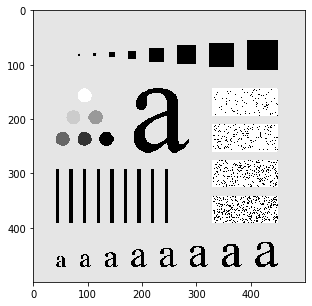

In [7]:
I = img.imread('docs/FigP0401(test_pattern).tif')
plt.imshow(I, cmap='gray')

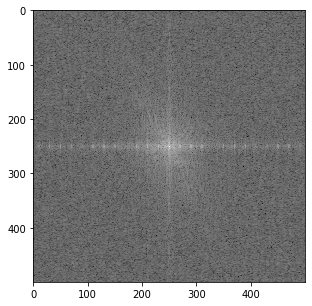

In [8]:
fft_viz(I)

In [9]:
pot_I = ImPotencia(I)
pot_I

11998178687.0

In [10]:
IB = FiltraGaussiana(I, sigma=16, kind='low')

In [11]:
pot_IB = ImPotencia(IB)
pot_IB

11284246183.392315

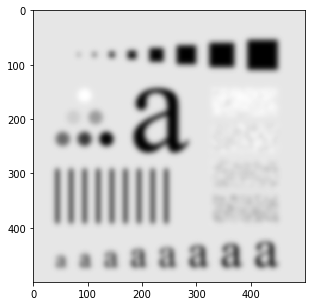

In [12]:
plt.imshow(IB, cmap='gray')

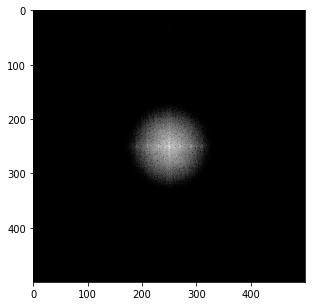

In [13]:
fft_viz(IB)

In [14]:
IA = FiltraGaussiana(I, sigma=16, kind='high')
pot_IA = ImPotencia(IA)
pot_IA

501456059.64718133

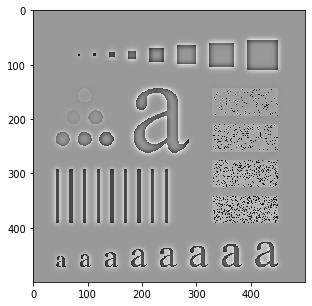

In [15]:
plt.imshow(IA, cmap='gray')

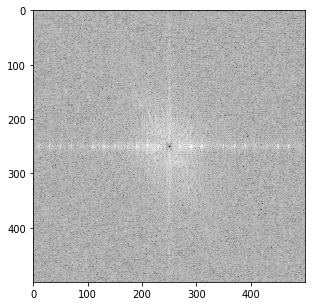

In [16]:
fft_viz(IA)

La función filtro_disco() sí funciona, lo que se ve aquí es un problema relacionado a la incapacidad del kernel de jupyter de manejar bien la memoria. Si ejecuta python ejemplo.py verá que el filtro sí funciona.

In [44]:
plt.imshow(filtro_disco(I), cmap='gray' )

ValueError: buffer source array is read-only

La diferencia en la potencia de las imágenes se debe a la cantidad de ceros que sus respectivas transformadas de fourier contienen.